In [51]:
import os

os.environ["CASTLE_BACKEND"] = "pytorch"
from castle.common import GraphDAG, priori_knowledge
from castle.metrics import MetricsDAG
from castle.algorithms import PC
import pandas as pd
import numpy as np

df = pd.read_csv("dataset.csv")
names = df.columns.to_list()[1:]
data = df.to_numpy()[:, 1:]

In [24]:
print(names)
print(data)
print(data.shape)

['Mood-0', 'Energy-0', 'Deep_work-0', 'Stoicism-0', 'Optimization_power-0', 'Sleep-0', 'Meditation-0', 'Sport-0', 'Social_interactions-0', 'Mood-1', 'Energy-1', 'Deep_work-1', 'Stoicism-1', 'Optimization_power-1', 'Sleep-1', 'Meditation-1', 'Sport-1', 'Social_interactions-1', 'Mood-2', 'Energy-2', 'Deep_work-2', 'Stoicism-2', 'Optimization_power-2', 'Sleep-2', 'Meditation-2', 'Sport-2', 'Social_interactions-2']
[[ 8.  7.  4. ... 20. 20.  2.]
 [ 7.  7.  6. ... 30.  5.  2.]
 [ 7.  6.  3. ... 30. 10.  2.]
 ...
 [ 8.  8.  2. ... 45. 20.  3.]
 [ 8.  8.  4. ... 45. 20.  6.]
 [ 9.  7.  2. ... 20. 30.  2.]]
(103, 27)


In [55]:
prior = priori_knowledge.PrioriKnowledge(len(names))
for i in range(len(names)):
    for j in range(len(names)):
        if names[i][-1] < names[j][-1]:
            prior.add_forbidden_edge(i, j)
pc = PC(priori_knowledge=prior)
pc.learn(data, names)


Mood-0 Social_interactions-0
Optimization_power-0 Meditation-0
Sport-0 Energy-0
Social_interactions-0 Deep_work-0
Mood-1 Energy-0
Energy-1 Mood-1
Deep_work-1 Deep_work-0
Stoicism-1 Stoicism-0
Stoicism-1 Mood-1
Meditation-1 Optimization_power-1
Sport-1 Energy-1
Social_interactions-1 Mood-1
Social_interactions-1 Deep_work-1
Mood-2 Energy-1
Mood-2 Stoicism-2
Mood-2 Social_interactions-2
Energy-2 Mood-2
Deep_work-2 Optimization_power-0
Deep_work-2 Deep_work-1
Deep_work-2 Optimization_power-1
Stoicism-2 Stoicism-0
Stoicism-2 Social_interactions-0
Stoicism-2 Stoicism-1
Stoicism-2 Social_interactions-1
Optimization_power-2 Deep_work-0
Optimization_power-2 Optimization_power-0
Optimization_power-2 Meditation-2
Meditation-2 Mood-0
Meditation-2 Meditation-0
Sport-2 Energy-2
Social_interactions-2 Stoicism-0
Social_interactions-2 Deep_work-2


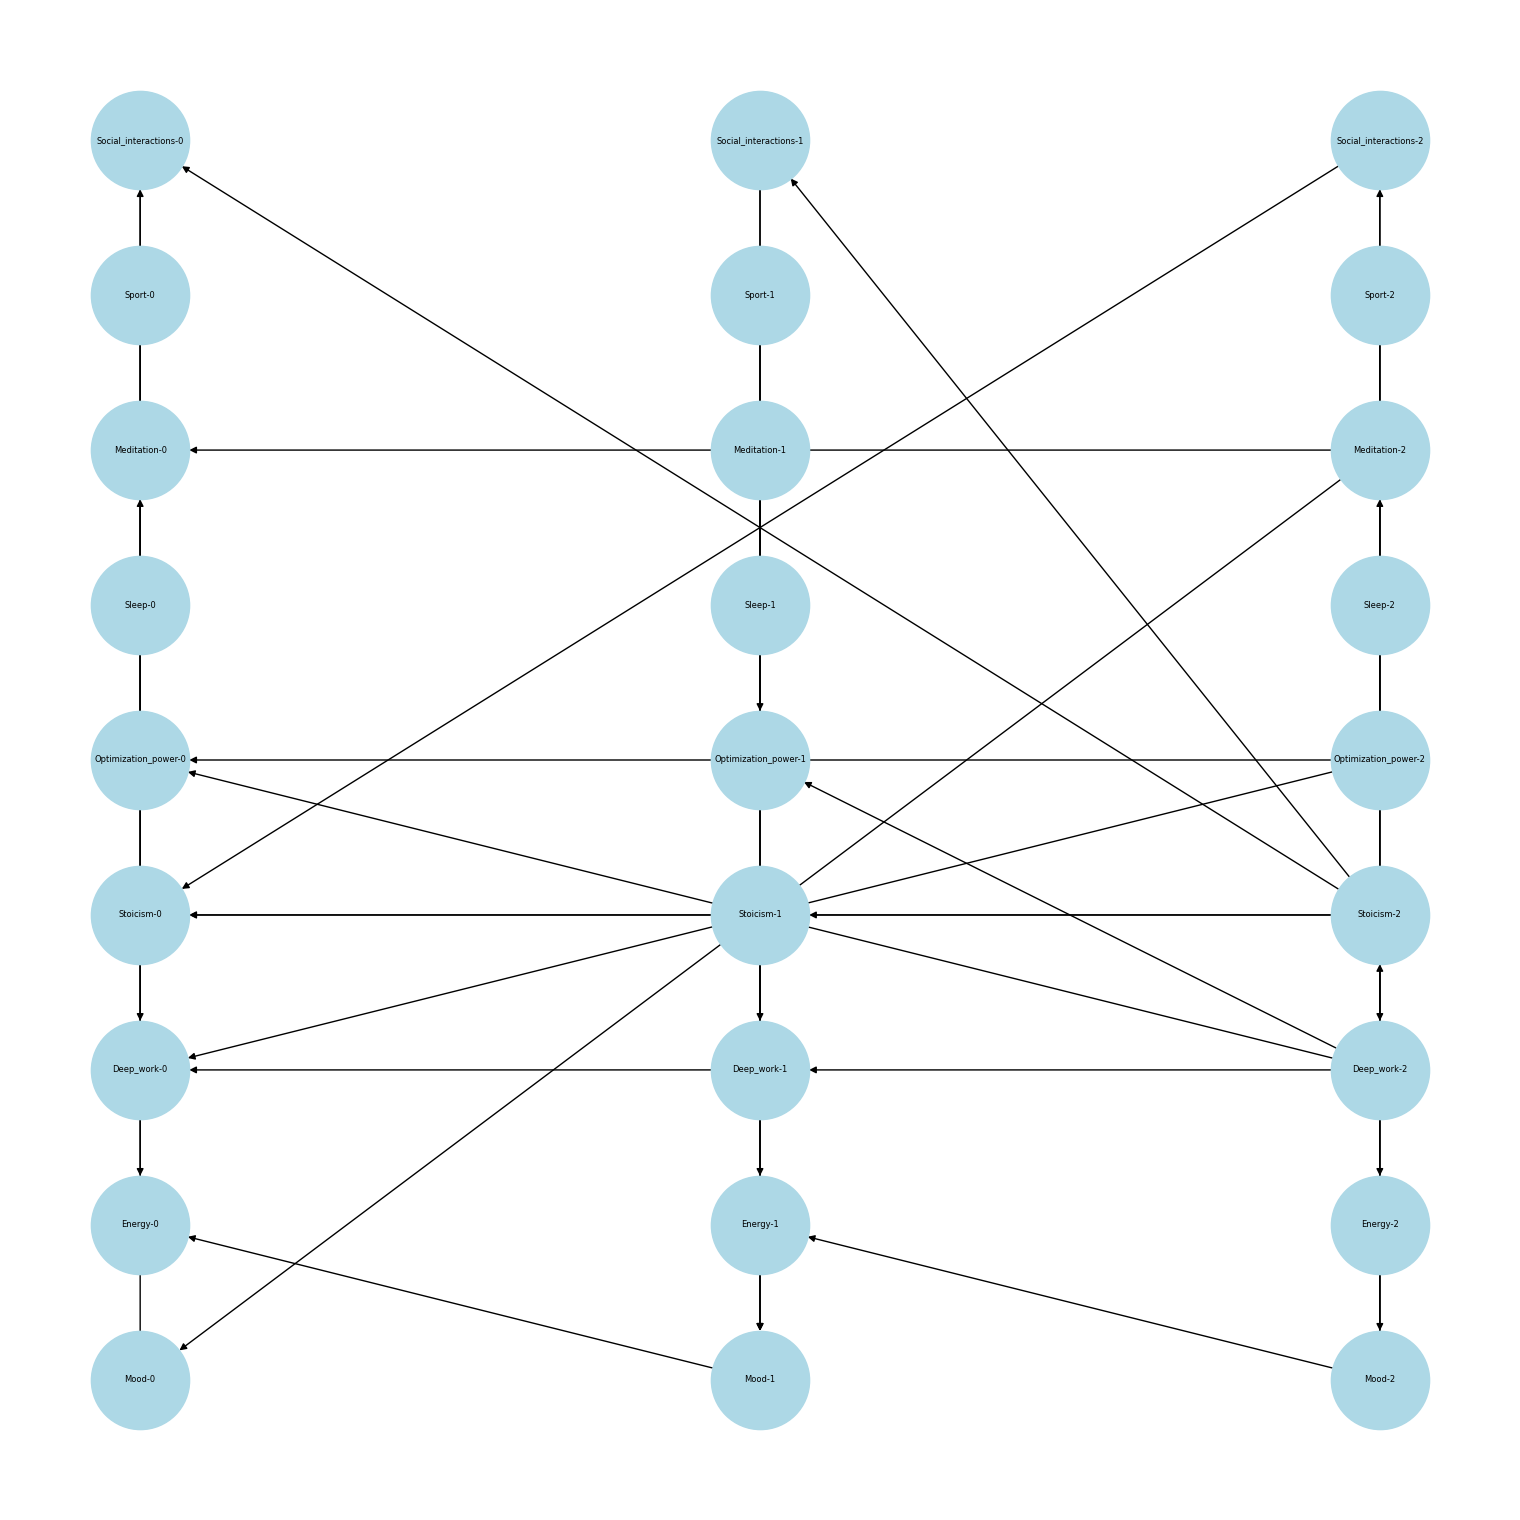

In [56]:
import networkx as nx
import matplotlib.pyplot as plt

adj_matrix = pc.causal_matrix
G = nx.DiGraph()

for name in names:
    G.add_node(name)

for i, row in enumerate(adj_matrix):
    for j, value in enumerate(row):
        if value:
            print(names[i], names[j])
            G.add_edge(names[i], names[j])

pos = {}
for name in names:
    _, n = name.split("-")
    x = int(n)
    y = sum(pos_x == x for (pos_x, _) in pos.values())
    pos[name] = (x, y)

plt.figure(figsize=(15, 15))
nx.draw(G, pos, with_labels=True, node_color="lightblue", font_size=6, node_size=5000)
# plt.show()
plt.savefig("dag.pdf")